In [1]:
import math
import numpy as np
import torch
from torch import nn

In [2]:
# 真实方程如下

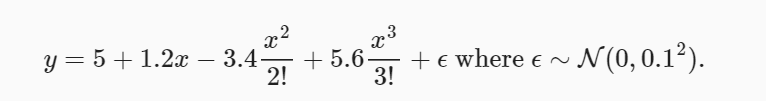

## 数据生成

In [3]:
max_degree = 20  # 多项式的最大阶数（这里直接取4不好吗）
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w).reshape((n_train + n_test, 1))  # 点乘
labels += np.random.normal(scale=0.1, size=labels.shape)

## 数据集制作

In [4]:
def loadArray(features, labels, batch_size, is_train=True):
    dataset = torch.utils.data.TensorDataset(features, labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)
    return dataloader

In [5]:
batch_size = min(10, poly_features.shape[0])

# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

train_loader = loadArray(poly_features[:n_train, :4], labels[:n_train], batch_size)
test_loader = loadArray(poly_features[n_train:, :4], labels[n_train:], batch_size)

## 网络模型

In [6]:
input_num = 4
output_num = 1
# 不设置偏置，因为我们已经在多项式中实现了它
# poly_features * true_w = labels，不设置偏置，线性层的权重正好为true_w
net = nn.Sequential(
    nn.Linear(input_num, output_num, bias=False)
)

## 损失函数 & 优化器

In [7]:
lr = 0.01
loss = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

## 数据统计函数

In [8]:
def accuracy(y_pre, y):
    """训练集准确率，应用于分类问题"""
    if len(y_pre.shape) > 1 and y_pre.shape[1] > 1:
        y_pre = torch.argmax(y_pre, axis=1)  # 分类问题
    cmp = (y_pre == y)
    return float(cmp.sum())

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_test(net, data_loader, loss):
    """测试数据集上进行评估"""
    metric = Accumulator(2)  # 测试数据集上的损失，准确率
    for X, y in data_loader:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(float(l.sum()), accuracy(out, y))
    return metric[0] / n_test, metric[1] / n_test

## 训练函数

In [9]:
def train(net, train_loader, loss, optimizer):
    if isinstance(net, nn.Module):
        net.train()
    metric = Accumulator(2)  # 后面要统计训练集损失，训练集准确率
    for X, y in train_loader:
        y_pre = net(X)
        l = loss(y_pre, y)
        if isinstance(optimizer, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        metric.add(float(l.sum()), accuracy(y_pre, y))
    return metric[0] / n_train, metric[1] / n_train

### 正常拟合

In [10]:
epochs = 400
for epoch in range(epochs):
    train_loss, _ = train(net, train_loader, loss, optimizer)
    print(epoch, "train_loss: ", train_loss)
    if (epoch + 1) % 20 == 0:
        test_loss, _ = evaluate_test(net, test_loader, loss)
        print(epoch, "test_loss: ", test_loss)

0 train_loss:  2.55821102142334
1 train_loss:  1.8449166107177735
2 train_loss:  1.3790075588226318
3 train_loss:  1.0689416646957397
4 train_loss:  0.8554395723342896
5 train_loss:  0.7056321239471436
6 train_loss:  0.6025066542625427
7 train_loss:  0.5185874474048614
8 train_loss:  0.45808829545974733
9 train_loss:  0.40898084282875063
10 train_loss:  0.3698444664478302
11 train_loss:  0.3364946985244751
12 train_loss:  0.30706611037254333
13 train_loss:  0.2838097071647644
14 train_loss:  0.260036832690239
15 train_loss:  0.2409714639186859
16 train_loss:  0.22407012045383454
17 train_loss:  0.2089025545120239
18 train_loss:  0.19373068273067473
19 train_loss:  0.18050798833370207
19 test_loss:  0.3305789905786514
20 train_loss:  0.1693505871295929
21 train_loss:  0.15809400081634523
22 train_loss:  0.14843464136123657
23 train_loss:  0.14075377762317656
24 train_loss:  0.13111480444669724
25 train_loss:  0.12367036342620849
26 train_loss:  0.11633597880601883
27 train_loss:  0.1099

289 train_loss:  0.0013332034554332495
290 train_loss:  0.0013227536575868726
291 train_loss:  0.0013170837517827748
292 train_loss:  0.001308416910469532
293 train_loss:  0.0012959805689752102
294 train_loss:  0.0012922201305627823
295 train_loss:  0.0012820965657010675
296 train_loss:  0.0012792141688987612
297 train_loss:  0.0012702751951292157
298 train_loss:  0.0012618678295984863
299 train_loss:  0.0012547606509178877
299 test_loss:  0.007889048019424081
300 train_loss:  0.0012538850540295243
301 train_loss:  0.0012410933105275034
302 train_loss:  0.0012330346251837908
303 train_loss:  0.0012295601982623338
304 train_loss:  0.0012208118941634894
305 train_loss:  0.0012145258206874131
306 train_loss:  0.0012099903612397612
307 train_loss:  0.001203360054641962
308 train_loss:  0.0011971033504232765
309 train_loss:  0.001192372664809227
310 train_loss:  0.0011874817032366991
311 train_loss:  0.001178813287988305
312 train_loss:  0.001174336215481162
313 train_loss:  0.0011659522075

In [11]:
net[0].weight.data

tensor([[ 5.0158,  1.2257, -3.3884,  5.4836]])

### 欠拟合

In [12]:
input_num = 2
net = nn.Sequential(
    nn.Linear(input_num, output_num, bias=False)
)
train_loader = loadArray(poly_features[:n_train, :input_num], labels[:n_train], batch_size)
test_loader = loadArray(poly_features[n_train:, :input_num], labels[n_train:], batch_size)

epochs = 400
for epoch in range(epochs):
    train_loss, _ = train(net, train_loader, loss, optimizer)
    print(epoch, "train_loss: ", train_loss)
    if (epoch + 1) % 20 == 0:
        test_loss, _ = evaluate_test(net, test_loader, loss)
        print(epoch, "test_loss: ", test_loss)

0 train_loss:  2.9889348411560057
1 train_loss:  2.9889348793029784
2 train_loss:  2.98893479347229
3 train_loss:  2.9889348220825194
4 train_loss:  2.9889347457885744
5 train_loss:  2.9889348793029784
6 train_loss:  2.988934860229492
7 train_loss:  2.9889348220825194
8 train_loss:  2.9889348220825194
9 train_loss:  2.9889348411560057
10 train_loss:  2.988934803009033
11 train_loss:  2.988934917449951
12 train_loss:  2.9889347648620603
13 train_loss:  2.988934860229492
14 train_loss:  2.9889348793029784
15 train_loss:  2.9889347648620603
16 train_loss:  2.988934917449951
17 train_loss:  2.9889348411560057
18 train_loss:  2.9889347457885744
19 train_loss:  2.9889347648620603
19 test_loss:  4.985845699310302
20 train_loss:  2.9889347457885744
21 train_loss:  2.9889347839355467
22 train_loss:  2.9889348983764648
23 train_loss:  2.9889348220825194
24 train_loss:  2.9889348411560057
25 train_loss:  2.988934803009033
26 train_loss:  2.9889347839355467
27 train_loss:  2.9889347839355467
28 tr

266 train_loss:  2.9889347839355467
267 train_loss:  2.9889348411560057
268 train_loss:  2.9889347457885744
269 train_loss:  2.9889347457885744
270 train_loss:  2.9889347839355467
271 train_loss:  2.9889347839355467
272 train_loss:  2.9889347839355467
273 train_loss:  2.9889347457885744
274 train_loss:  2.9889347648620603
275 train_loss:  2.988934803009033
276 train_loss:  2.9889347839355467
277 train_loss:  2.9889347839355467
278 train_loss:  2.988934917449951
279 train_loss:  2.9889347648620603
279 test_loss:  4.985845718383789
280 train_loss:  2.988934917449951
281 train_loss:  2.9889347839355467
282 train_loss:  2.9889348793029784
283 train_loss:  2.9889348411560057
284 train_loss:  2.9889347839355467
285 train_loss:  2.9889347839355467
286 train_loss:  2.9889348983764648
287 train_loss:  2.988934860229492
288 train_loss:  2.9889347457885744
289 train_loss:  2.988934860229492
290 train_loss:  2.988934917449951
291 train_loss:  2.9889347839355467
292 train_loss:  2.9889347743988037


In [13]:
net[0].weight.data

tensor([[-0.2731, -0.3153]])

### 过拟合

In [14]:
input_num = 20
net = nn.Sequential(
    nn.Linear(input_num, output_num, bias=False)
)
train_loader = loadArray(poly_features[:n_train, :input_num], labels[:n_train], batch_size)
test_loader = loadArray(poly_features[n_train:, :input_num], labels[n_train:], batch_size)

epochs = 400
for epoch in range(epochs):
    train_loss, _ = train(net, train_loader, loss, optimizer)
    print(epoch, "train_loss: ", train_loss)
    if (epoch + 1) % 20 == 0:
        test_loss, _ = evaluate_test(net, test_loader, loss)
        print(epoch, "test_loss: ", test_loss)

0 train_loss:  2.7043732452392577
1 train_loss:  2.7043731880187987
2 train_loss:  2.704373207092285
3 train_loss:  2.7043733406066894
4 train_loss:  2.7043731689453123
5 train_loss:  2.7043731689453123
6 train_loss:  2.704373254776001
7 train_loss:  2.7043732261657714
8 train_loss:  2.7043731784820557
9 train_loss:  2.7043732261657714
10 train_loss:  2.7043731689453123
11 train_loss:  2.7043731689453123
12 train_loss:  2.7043731880187987
13 train_loss:  2.7043732833862304
14 train_loss:  2.7043733024597167
15 train_loss:  2.704373264312744
16 train_loss:  2.704373016357422
17 train_loss:  2.7043730926513674
18 train_loss:  2.7043730926513674
19 train_loss:  2.7043731212615967
19 test_loss:  4.484903602600098
20 train_loss:  2.7043731689453123
21 train_loss:  2.7043732261657714
22 train_loss:  2.7043731784820557
23 train_loss:  2.7043731880187987
24 train_loss:  2.704373197555542
25 train_loss:  2.7043732833862304
26 train_loss:  2.7043731880187987
27 train_loss:  2.7043731689453123
28

242 train_loss:  2.7043731594085694
243 train_loss:  2.7043731307983396
244 train_loss:  2.7043731689453123
245 train_loss:  2.704373264312744
246 train_loss:  2.7043732833862304
247 train_loss:  2.704373207092285
248 train_loss:  2.7043731689453123
249 train_loss:  2.7043731880187987
250 train_loss:  2.704373207092285
251 train_loss:  2.7043731117248537
252 train_loss:  2.7043731784820557
253 train_loss:  2.7043731689453123
254 train_loss:  2.704373149871826
255 train_loss:  2.704373207092285
256 train_loss:  2.704373149871826
257 train_loss:  2.7043731117248537
258 train_loss:  2.704373264312744
259 train_loss:  2.704373149871826
259 test_loss:  4.484903469085693
260 train_loss:  2.7043732833862304
261 train_loss:  2.704373149871826
262 train_loss:  2.704373254776001
263 train_loss:  2.7043733024597167
264 train_loss:  2.704373140335083
265 train_loss:  2.704373207092285
266 train_loss:  2.704373207092285
267 train_loss:  2.704373149871826
268 train_loss:  2.704373149871826
269 train

In [15]:
net[0].weight.data

tensor([[ 0.1078, -0.2056,  0.1194, -0.1864,  0.2000, -0.0049, -0.0409, -0.0948,
         -0.0329,  0.1334,  0.1239,  0.1186, -0.0459,  0.0271,  0.1342,  0.1500,
          0.0598,  0.0550, -0.2014, -0.0969]])

## L2正则化（防止过拟合）

In [22]:
# 在优化器中加入weight_decay参数，但是还不知道怎么确定weight_decay
weight_decay = 1e-4
input_num = 20
output_num = 1

# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in
                                           [true_w, features, poly_features, labels]]

train_loader = loadArray(poly_features[:n_train, :input_num], labels[:n_train], batch_size)
test_loader = loadArray(poly_features[n_train:, :input_num], labels[n_train:], batch_size)

net = nn.Sequential(
    nn.Linear(input_num, output_num, bias=False)
)

# 优化器中加入weight_decay参数
lr = 0.01
loss = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)

epochs = 400
for epoch in range(epochs):
    train_loss, _ = train(net, train_loader, loss, optimizer)
    print(epoch, "train_loss: ", train_loss)
    if (epoch + 1) % 20 == 0:
        test_loss, _ = evaluate_test(net, test_loader, loss)
        print(epoch, "test_loss: ", test_loss)

print(net[0].weight.norm().item())
print(net[0].weight.data)

C:\Users\Yan\AppData\Local\Temp\ipykernel_23992\1338213009.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in


0 train_loss:  2.167507381439209
1 train_loss:  1.5838525009155273
2 train_loss:  1.2151785230636596
3 train_loss:  0.9459301042556763
4 train_loss:  0.7643800687789917
5 train_loss:  0.6425672388076782
6 train_loss:  0.548407654762268
7 train_loss:  0.48396779417991637
8 train_loss:  0.421153427362442
9 train_loss:  0.3790281975269318
10 train_loss:  0.3427979850769043
11 train_loss:  0.312842390537262
12 train_loss:  0.2872386109828949
13 train_loss:  0.2648416483402252
14 train_loss:  0.24570578455924988
15 train_loss:  0.22741203308105468
16 train_loss:  0.21196664810180665
17 train_loss:  0.19772797346115112
18 train_loss:  0.18490621268749238
19 train_loss:  0.172829470038414
19 test_loss:  0.6325866460800171
20 train_loss:  0.16261752545833588
21 train_loss:  0.1529921406507492
22 train_loss:  0.14510275542736054
23 train_loss:  0.13654311060905455
24 train_loss:  0.1293346905708313
25 train_loss:  0.12301763772964477
26 train_loss:  0.11643536567687988
27 train_loss:  0.1107660

307 train_loss:  0.001960717895999551
308 train_loss:  0.0019567079190164803
309 train_loss:  0.0019555699266493322
310 train_loss:  0.0019370961841195821
311 train_loss:  0.0019370533525943756
312 train_loss:  0.0019266691850498318
313 train_loss:  0.0019257957488298416
314 train_loss:  0.001919765411876142
315 train_loss:  0.0019103243201971055
316 train_loss:  0.001899999240413308
317 train_loss:  0.0018994388729333877
318 train_loss:  0.0018917240109294652
319 train_loss:  0.0018874911312013864
319 test_loss:  0.00577513222116977
320 train_loss:  0.00188315499573946
321 train_loss:  0.0018710606638342143
322 train_loss:  0.0018799310084432364
323 train_loss:  0.001863116854801774
324 train_loss:  0.001858607642352581
325 train_loss:  0.001847792873159051
326 train_loss:  0.0018424732610583306
327 train_loss:  0.001844533197581768
328 train_loss:  0.0018308104760944844
329 train_loss:  0.0018290576431900262
330 train_loss:  0.0018215703312307596
331 train_loss:  0.001820043474435806

In [ ]:
|